# preprocess EDR data

In [1]:
import os
import numpy as np 
import torch
import astropy.io.fits as fits
from astropy.table import Table, vstack

In [2]:
import matplotlib.pyplot as plt

In [3]:
# Fuji catalog with BAL and DLAs included
#qsos = Table.read('/global/cfs/cdirs/desi/public/edr/vac/edr/qso/v1.0/QSO_cat_fuji_healpix_for_lyalpha.fits')

# Guadalupe SV1, SV3, M2
qsos = Table.read('/global/cfs/projectdirs/desi/users/sgontcho/lya/spender-lya/QSO_cat_EDR_n_M2_main_dark_healpix_BAL_n_DLA_cuts.fits')
print('%i QSOs' % len(qsos))

310225 QSOs


In [4]:
qsos

TARGETID,Z,ZERR,ZWARN,SPECTYPE,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,PROBA_RF,MASKBITS,SV1_DESI_TARGET,SV1_SCND_TARGET,DESI_TARGET,COADD_NUMEXP,COADD_EXPTIME,CMX_TARGET,SV2_DESI_TARGET,SV3_DESI_TARGET,SV2_SCND_TARGET,SV3_SCND_TARGET,SCND_TARGET,TSNR2_LYA,TSNR2_QSO,DELTA_CHI2_MGII,A_MGII,SIGMA_MGII,B_MGII,VAR_A_MGII,VAR_SIGMA_MGII,VAR_B_MGII,Z_RR,Z_QN,C_LYA,C_CIV,C_CIII,C_MgII,C_Hbeta,C_Halpha,Z_LYA,Z_CIV,Z_CIII,Z_MgII,Z_Hbeta,Z_Halpha,QSO_MASKBITS,HPXPIXEL,SURVEY,PROGRAM,LASTNIGHT,PCA_COEFFS,PCA_CHI2,BAL_PROB,BI_CIV,ERR_BI_CIV,NCIV_2000,VMIN_CIV_2000,VMAX_CIV_2000,POSMIN_CIV_2000,FMIN_CIV_2000,AI_CIV,ERR_AI_CIV,NCIV_450,VMIN_CIV_450,VMAX_CIV_450,POSMIN_CIV_450,FMIN_CIV_450,BI_SIIV,ERR_BI_SIIV,NSIIV_2000,VMIN_SIIV_2000,VMAX_SIIV_2000,POSMIN_SIIV_2000,FMIN_SIIV_2000,AI_SIIV,ERR_AI_SIIV,NSIIV_450,VMIN_SIIV_450,VMAX_SIIV_450,POSMIN_SIIV_450,FMIN_SIIV_450,BALMASK
int64,float64,float64,int64,bytes6,int32,float64,float64,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,int16,int64,int64,int64,int16,float32,int64,int64,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int64,bytes4,bytes4,int64,float32[5],float32,float32,float32,float32,int32,float32[5],float32[5],float32[5],float32[5],float32,float32,int32,float32[17],float32[17],float32[17],float32[17],float32,float32,int32,float32[5],float32[5],float32[5],float32[5],float32,float32,int32,float32[17],float32[17],float32[17],float32[17],uint8
39628357184262231,0.8135438091215956,1.5672871326882497e-05,0,QSO,0,197.20380147240678,24.35077016605972,PSF,0.017858109,10.67686,12.232638,13.990282,18.791878,25.714027,340.31104,141.27417,46.01317,2.7972982,0.6816619,0.9419676772657593,0.9419676772657593,0.9419676772657593,0.9419676772657593,0.9419676772657593,0.9982012715339661,0,6971572223169576964,34359869440,0,6,4035.6438,0,0,0,0,0,0,348.1467,146.4321,1155.9159,3.0262625,12.303644,4.8029118,0.0077066594,0.1702219,0.0004896629,0.8135438,0.8173587,4.3181073e-05,9.325928e-05,0.00045707618,0.9999993,0.9999999,6.455496e-05,4.289906,4.248765,2.667304,0.8170264,0.8173587,-0.2528662,14,10282,sv1,dark,20210403,0.0 .. 0.0,0.0,-99.0,0.0,0.0,0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0,0.0,0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0,0.0,0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0,0.0,0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,5
39628368190116444,1.6409069675992565,0.00021919304399655947,0,QSO,0,197.00109823431288,24.66032672738624,PSF,0.018184515,1.4136646,1.8319082,2.519458,3.8480425,3.951792,1528.1095,366.21558,96.183365,3.8174903,0.8200599,0.9409389293341086,0.9409389293341086,0.9409389293341086,0.9409389293341086,0.9409389293341086,0.966326452627778,0,54044020162216710,0,0,6,4035.6438,0,0,0,0,0,0,660.66315,178.28696,21.223158,0.124089785,24.529495,0.3829324,0.0005878671,37.661903,0.00013564747,1.6409069,1.6483291,0.0006857977,0.9999983,0.9999989,0.999995,0.0011047213,0.0003636595,2.282556,1.6411955,1.6483291,1.6497874,0.2979616,0.25666577,14,10282,sv1,dark,20210403,26.846205 .. 0.839694,1.2286985,0.0,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,-1.0 .. -1.0,-1.0 .. -1.0,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,-1.0 .. -1.0,-1.0 .. -1.0,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,-1.0 .. -1.0,-1.0 .. -1.0,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,-1.0 .. -1.0,-1.0 .. -1.0,0
39628362695576213,1.2575804648362574,0.00015636319483336555,0,QSO,0,197.13340485280958,24.60784831379928,PSF,0.018701294,4.754353,6.518687,5.0220294,13.427239,18.577494,1018.86536,361.23877,82.47155,3.474163,0.7590202,0.9393124704066372,0.9393124704066372,0.9393124704066372,0.939312

# lets take a look a couple spectra

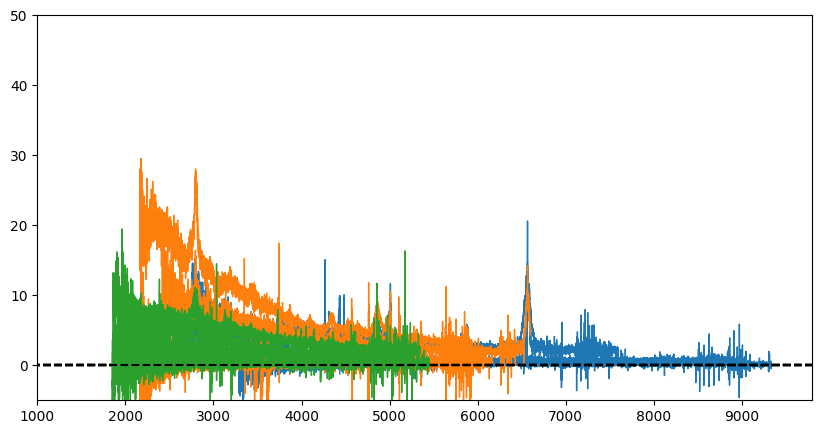

In [10]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for ii, zlow, zhigh in zip(np.arange(3), np.linspace(0., 1., 4)[:-1], np.linspace(0., 1., 4)[1:]): 
    zbin = (qsos['Z'] > zlow) & (qsos['Z'] < zhigh)
   
    for igal in np.random.choice(np.arange(len(qsos))[zbin], size=5): 
        if qsos['SURVEY'][igal] in ['sv1', 'sv3']: 
            spec_dir = '/global/cfs/projectdirs/desi/spectro/redux/fuji/healpix/'
        elif qsos['SURVEY'][igal] in ['main']: 
            spec_dir = '/global/cfs/projectdirs/desi/spectro/redux/guadalupe/healpix/'
        else: 
            print(qsos['SURVEY'][igal])
            raise ValueError

        fspec = os.path.join(spec_dir, qsos['SURVEY'][igal], qsos['PROGRAM'][igal], 
                             str(qsos['HPXPIXEL'][igal])[:-2], str(qsos['HPXPIXEL'][igal]), 
                             'coadd-%s-%s-%i.fits' % (qsos['SURVEY'][igal], qsos['PROGRAM'][igal], qsos['HPXPIXEL'][igal]))
        hdulist = fits.open(fspec)
        survey = hdulist[0].header['SURVEY'].upper()
        meta = Table.read(fspec) # meta data
        target_id = hdulist[1].data['TARGETID'] # unique target ID

        is_gal = (target_id == qsos['TARGETID'][igal])
        assert np.sum(is_gal) == 1

        sub.plot(hdulist[3].data/(1+qsos['Z'][igal]), hdulist[4].data[is_gal][0], lw=1, c='C%i' % ii)
        sub.plot(hdulist[8].data/(1+qsos['Z'][igal]), hdulist[9].data[is_gal][0], lw=1, c='C%i' % ii)
        sub.plot(hdulist[13].data/(1+qsos['Z'][igal]), hdulist[14].data[is_gal][0], lw=1, c='C%i' % ii)
        sub.plot([0., 1e4], [0., 0.], ls='--', c='k') 
sub.set_xlim(1e3, 9.8e3)
sub.set_ylim(-5, 50)
plt.show()

# preprocess spectra

In [11]:
from spenderq import desi_qso

In [12]:
desiQSO = desi_qso.DESI()

In [13]:
def prepare_spectra(survey, program, hpix, qso, zbin='high'): 
    ''' prepare QSO spectra in healpix 
    '''
    if survey in ['sv1', 'sv3']: 
        spec_dir = '/global/cfs/projectdirs/desi/spectro/redux/fuji/healpix/'
    elif survey in ['main']: 
        spec_dir = '/global/cfs/projectdirs/desi/spectro/redux/guadalupe/healpix/'
    else: 
        raise ValueError
    filename = os.path.join(spec_dir, '%s/%s' % (survey, program), str(hpix)[:-2], str(hpix), 
                                "coadd-%s-%s-%i.fits" % (survey, program, hpix))
    # read spectra file
    hdulist = fits.open(filename)
    survey = hdulist[0].header['SURVEY'].upper()
    meta = Table.read(filename) # meta data
    target_id = hdulist[1].data['TARGETID'] # unique target ID

    keep = np.zeros(len(meta)).astype(bool)
    z, zerr = np.zeros(len(meta)), np.zeros(len(meta))

    qso_hpix = qso[(qso['SURVEY'] == survey.lower()) & (qso['PROGRAM'] == program) & (qso['HPXPIXEL'] == hpix)]

    for targetid, _z, _zerr in zip(qso_hpix['TARGETID'], qso_hpix['Z'], qso_hpix['ZERR']): 
        keep = keep | (target_id == targetid)
        z[target_id == targetid] = _z
        zerr[target_id == targetid] = _zerr
    
    # read in data
    _wave, _flux, _ivar, _mask, _res = {}, {}, {}, {}, {}
    for h in range(2, len(hdulist)):
        if "WAVELENGTH" in hdulist[h].header["EXTNAME"]:
            band = hdulist[h].header["EXTNAME"].split("_")[0].lower()
            _wave[band] = hdulist[h].data
        if "FLUX" in hdulist[h].header["EXTNAME"]:
            band = hdulist[h].header["EXTNAME"].split("_")[0].lower()
            _flux[band] = hdulist[h].data
        if "IVAR" in hdulist[h].header["EXTNAME"]:
            band = hdulist[h].header["EXTNAME"].split("_")[0].lower()
            _ivar[band] = hdulist[h].data
        if "MASK" in hdulist[h].header["EXTNAME"]:
            band = hdulist[h].header["EXTNAME"].split("_")[0].lower()
            _mask[band] = hdulist[h].data
        if "RESOLUTION" in hdulist[h].header["EXTNAME"]:
            band = hdulist[h].header["EXTNAME"].split("_")[0].lower()
            _res[band] = hdulist[h].data
    # coadd the b, r, z arm spectra (scraped from
    # https://github.com/desihub/desispec/blob/main/py/desispec/coaddition.py#L529)
    tolerance = 0.0001  # A , tolerance
    wave = _wave["b"]
    for b in ["b", "r", "z"]:
        wave = np.append(wave, _wave[b][_wave[b] > wave[-1] + tolerance])
    nwave = wave.size
    ntarget = _flux["b"].shape[0]
    check_agreement = torch.abs(torch.from_numpy(wave) - desiQSO._wave_obs)
    if check_agreement.max() > tolerance:
        print(
            "Warning: input wavelength grids inconsistent with class variable wave_obs!"
        )
    # check alignment, caching band wavelength grid indices as we go
    windict = {}
    number_of_overlapping_cameras = np.zeros(nwave)
    for b in ["b", "r", "z"]:
        imin = np.argmin(np.abs(_wave[b][0] - wave))
        windices = np.arange(imin, imin + len(_wave[b]), dtype=int)
        dwave = _wave[b] - wave[windices]

        if np.any(np.abs(dwave) > tolerance):
            msg = "Input wavelength grids (band '{}') are not aligned. Use --lin-step or --log10-step to resample to a common grid.".format(
                b
            )
            raise ValueError(msg)
        number_of_overlapping_cameras[windices] += 1
        windict[b] = windices

    # ndiag = max of all cameras
    ndiag = 0
    for b in ["b", "r", "z"]:
        ndiag = max(ndiag, _res[b].shape[1])

    flux = np.zeros((ntarget, nwave), dtype=_flux["b"].dtype)
    ivar = np.zeros((ntarget, nwave), dtype=_ivar["b"].dtype)
    ivar_unmasked = np.zeros((ntarget, nwave), dtype=_ivar["b"].dtype)
    mask = np.zeros((ntarget, nwave), dtype=_mask["b"].dtype)
    rdata = np.zeros((ntarget, ndiag, nwave), dtype=_res["b"].dtype)

    for b in ["b", "r", "z"]:
        # indices
        windices = windict[b]

        band_ndiag = _res[b].shape[1]

        for i in range(ntarget):
            ivar_unmasked[i, windices] += np.sum(_ivar[b][i], axis=0)
            ivar[i, windices] += _ivar[b][i] * (_mask[b][i] == 0)
            flux[i, windices] += _ivar[b][i] * (_mask[b][i] == 0) * _flux[b][i]
            for r in range(band_ndiag):
                rdata[i, r + (ndiag - band_ndiag) // 2, windices] += (
                    _ivar[b][i] * _res[b][i, r]
                )

            # directly copy mask where no overlap
            jj = number_of_overlapping_cameras[windices] == 1
            mask[i, windices[jj]] = _mask[b][i][jj]

            # 'and' in overlapping regions
            jj = number_of_overlapping_cameras[windices] > 1
            mask[i, windices[jj]] = mask[i, windices[jj]] & _mask[b][i][jj]

    for i in range(ntarget):
        ok = ivar[i] > 0
        if np.sum(ok) > 0:
            flux[i][ok] /= ivar[i][ok]
        ok = ivar_unmasked[i] > 0
        if np.sum(ok) > 0:
            rdata[i][:, ok] /= ivar_unmasked[i][ok]
            
    # apply bitmask, remove small values
    mask = mask.astype(bool) | (ivar <= 1e-6)
    ivar[mask] = 0

    # explicit type conversion to float32 to get to little endian
    spec = torch.from_numpy(flux[keep].astype(np.float32))
    w = torch.from_numpy(ivar[keep].astype(np.float32))
    target_id = torch.from_numpy(target_id[keep].astype(np.int64))

    # remove regions around skylines
    w[:, desiQSO._skyline_mask] = 0
    
    z = torch.tensor(z[keep].astype(np.float32))
    zerr = torch.tensor(zerr[keep].astype(np.float32))
    
    # normalize spectra:
    norm = torch.zeros(np.sum(keep))
    for i in range(np.sum(keep)):
        # for redshift invariant encoder: select norm window in restframe
        wave_rest = desiQSO._wave_obs / (1 + z[i])
        # wavelength range with no spectral lines
        if zbin == 'low': 
            sel = (w[i] > 0) & (wave_rest > 2500) & (wave_rest < 2700) #(wave_rest > 5300) & (wave_rest < 5850)
        elif zbin == 'high': 
            # this wavelength range is set by the CIII absorprtion wavelengths. 
            # CIII absorption is small and thus should not contribute significantly
            # to estimating the normalization
            sel = (w[i] > 0) & (wave_rest > 1600) & (wave_rest < 1800) #(wave_rest > 5300) & (wave_rest < 5850)
        else: 
            raise NotImplementedError
        if sel.count_nonzero() > 0:
            norm[i] = torch.median(spec[i][sel])
        # remove spectra (from training) for which no valid norm could be found
        if not torch.isfinite(norm[i]):
            norm[i] = 0
        else:
            spec[i] /= norm[i]
        w[i] *= norm[i]**2

    # selects finite fluxes
    keep = (spec.isfinite().sum(axis=-1) == nwave).numpy()
    print("keep: %d / %d"%(keep.sum(),len(keep)))
    return spec[keep], w[keep], z[keep], target_id[keep],  norm[keep], zerr[keep]

split QSO data set into two redshift bins: z < 2.1 and 2.1 < z < 3.5

In [14]:
#qso_lowz = qsos[(qsos['Z'] > 0.5) & (qsos['Z'] < 2.1)]
qso_highz = qsos[(qsos['Z'] > 2.1) & (qsos['Z'] < 3.5)]

In [15]:
len(qso_highz)

86623

In [21]:
spec, w, z, target_id, norm, zerr = prepare_spectra('sv1', 'dark', 10282, qso_highz)

keep: 2 / 2


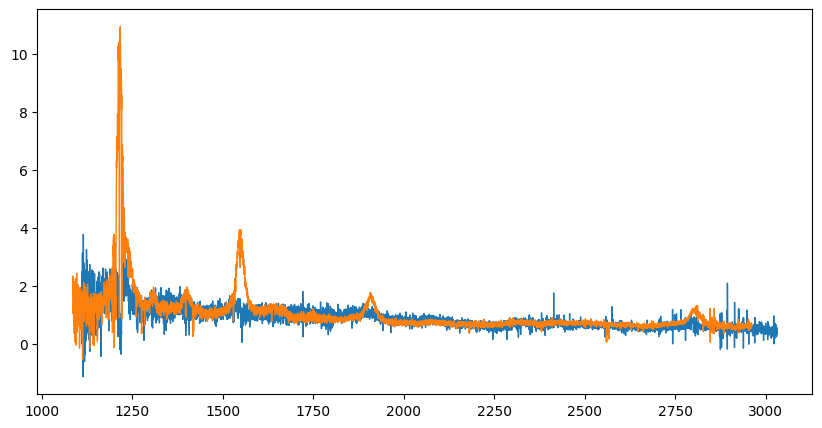

In [22]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for _spec, _z in zip(spec, z):
    sub.plot(desiQSO._wave_obs / (1 + _z), _spec, lw=1)

#sub.set_ylim(-10, 10)

In [23]:
# save QSO spectra to batch
batch_size = 1024

counter, new_batch = 0, True

for survey in ['sv1', 'sv3', 'main']: 
    hpixs = qso_highz['HPXPIXEL'][qso_highz['SURVEY'] == survey]
    
    for hpix in np.unique(hpixs): 
        print(survey, hpix)
        spec, w, z, target_id, norm, zerr = prepare_spectra(survey, 'dark', hpix, qso_highz, zbin='high')

        if new_batch:
            batches = [spec, w, z, target_id, norm, zerr]
            new_batch = False
        else:
            batches[0] = torch.concatenate([batches[0], spec], axis=0)
            batches[1] = torch.concatenate([batches[1], w], axis=0)
            batches[2] = torch.concatenate([batches[2], z], axis=0)
            batches[3] = torch.concatenate([batches[3], target_id], axis=0)
            batches[4] = torch.concatenate([batches[4], norm], axis=0)
            batches[5] = torch.concatenate([batches[5], zerr], axis=0)

        N = batches[0].shape[0]
        while N > batch_size:
            batch = [_batch[:batch_size] for _batch in batches]

            print(f"saving batch {counter}")
            desiQSO.save_batch('/global/cfs/projectdirs/desi/users/chahah/spender_qso', batch, tag='.edr.qso_highz', counter=counter)
            counter += 1
            N -= batch_size

            batches = [_batch[batch_size:] for _batch in batches]

sv1 4679
keep: 2 / 2
sv1 4685
keep: 8 / 8
sv1 4690
keep: 2 / 2
sv1 4691
keep: 1 / 1
sv1 4696
keep: 2 / 2
sv1 4697
keep: 2 / 2
sv1 4698
keep: 2 / 2
sv1 4699
keep: 3 / 3
sv1 4702
keep: 5 / 5
sv1 4703
keep: 7 / 7
sv1 4720
keep: 2 / 2
sv1 4721
keep: 4 / 4
sv1 4723
keep: 15 / 15
sv1 4724
keep: 9 / 9
sv1 4725
keep: 12 / 12
sv1 4726
keep: 18 / 18
sv1 4727
keep: 8 / 8
sv1 4729
keep: 1 / 1
sv1 4732
keep: 5 / 5
sv1 4733
keep: 10 / 10
sv1 4736
keep: 2 / 2
sv1 4738
keep: 16 / 16
sv1 4744
keep: 12 / 12
sv1 4746
keep: 8 / 8
sv1 4768
keep: 15 / 15
sv1 4769
keep: 10 / 10
sv1 4770
keep: 18 / 18
sv1 4771
keep: 11 / 11
sv1 4774
keep: 3 / 3
sv1 4776
keep: 10 / 10
sv1 4777
keep: 14 / 14
sv1 4778
keep: 4 / 4
sv1 4779
keep: 3 / 3
sv1 4780
keep: 1 / 1
sv1 4896
keep: 6 / 6
sv1 4898
keep: 10 / 10
sv1 4904
keep: 4 / 4
sv1 4955
keep: 9 / 9
sv1 4957
keep: 3 / 3
sv1 4958
keep: 28 / 28
sv1 4959
keep: 25 / 25
sv1 4967
keep: 13 / 13
sv1 4972
keep: 3 / 3
sv1 4973
keep: 14 / 14
sv1 4974
keep: 6 / 6
sv1 4975
keep: 21 / 2

In [ ]:
print(counter)

84


In [ ]:
batch = [_batch[:batch_size] for _batch in batches]
desiQSO.save_batch('/global/cfs/projectdirs/desi/users/chahah/spender_qso', batch, tag='.edr.qso_highz', counter=counter)

'/global/cfs/projectdirs/desi/users/chahah/spender_qso/DESI.edr.qso_highz_84.pkl'